<a href="https://colab.research.google.com/github/JonasMiksch/Research_Project_SimCLR/blob/main/Pretraining_SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm
#from torchvision.datasets import STL10
## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from math import sqrt, ceil, floor
from statistics import mean

from torchvision.io import read_image
from random import randint

from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torchvision.utils import make_grid
from torch.nn import functional as F
import torch

try:
    import wandb
except ModuleNotFoundError: 
    !pip3 install wandb
    import wandb

try:
    import torchinfo
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip3 install torchinfo
    import torchinfo

## Torchvision
import torchvision
from torchvision import transforms
from torchvision import models
import numpy as np
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip3 install --quiet pytorch-lightning>=1.4 # type : ignore
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import pandas as pd
import pdb
from torch.utils.data import DataLoader,Dataset
# Import tensorboard
%reload_ext tensorboard


# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 181 kB 46.0 MB/s 
     |████████████████████████████████| 144 kB 48.5 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=f302690db4de86a5c4f864c505774dd1738c0b976d0ae75758b142eccc747fd9
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Global seed set to 42


Device: cuda:0


**TODO : Change Paths Here and deactivate colab**

In [ ]:
#TODO comment when not working with colab
from google.colab import drive
drive.mount("/content/gdrive")
!unzip gdrive/My\ Drive/Seminararbeit/JPEGImages.zip > /dev/null
#


Mounted at /content/gdrive


In [ ]:

#Dataset_Paths TODO Change these accordingly
WORKING_DIRECTORY = '/content/gdrive/My Drive/Seminararbeit'
ARTDL_CSV_PATH = WORKING_DIRECTORY
WIKI_CSV_PATH = WORKING_DIRECTORY
WIKI_IMAGE_FOLDERS_PATH = WORKING_DIRECTORY
img_folder = 'JPEGImages'




# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH =  os.path.join(WORKING_DIRECTORY,"checkpoints")

#Change the training type




In [42]:
trainingSimCLR = False
trainingArtDl = False
trainingWiki = True

**Define Lightning Module for Style Transfer**

In [ ]:
# STOP COLLAB FROM DISCONNECTING

# function ConnectButton(){
#     console.log("Connect pushed"); 
#     document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }

# var colab = setInterval(ConnectButton,60000);

class MSEContentLoss(nn.Module):
    # https://arxiv.org/pdf/1508.06576.pdf

    def forward(self, x, y):
        return F.mse_loss(x, y)


class GramStyleLoss(nn.Module):
    # https://arxiv.org/pdf/1508.06576.pdf

    def forward(self, x, y):
        gram_diff = self.gram_matrix(x) - self.gram_matrix(y)
        return torch.mean(torch.sum(gram_diff ** 2, dim=[1, 2]))

    def gram_matrix(self, x):
        n, c, h, w = x.size()
        x = x.view(n, c, h * w)
        return x @ x.transpose(-2, -1) / (c * h * w)


class MomentMatchingStyleLoss(nn.Module):
    # https://arxiv.org/pdf/1703.06868.pdf

    def forward(self, x, y):
        x_mean = torch.mean(x, dim=[2, 3])
        y_mean = torch.mean(y, dim=[2, 3])
        mean_loss = F.mse_loss(x_mean, y_mean)

        x_std = torch.std(x, dim=[2, 3])
        y_std = torch.std(y, dim=[2, 3])
        std_loss = F.mse_loss(x_std, y_std)

        return mean_loss + std_loss


class CMDStyleLoss(nn.Module):
    # https://arxiv.org/pdf/2103.07208.pdf
    # CMDStyleLoss works with pre-activation outputs of VGG19 (without ReLU)

    def __init__(self, k=5):
        super().__init__()
        self.k = k

    def forward(self, x, y):
        x, y = torch.sigmoid(x), torch.sigmoid(y)

        loss = 0
        for x_k, y_k in zip(self.moments(x), self.moments(y)):
            loss += self.l2_dist(x_k, y_k).mean()
        return loss

    def moments(self, x):
        # First vectorize feature maps
        n, c, h, w = x.size()
        x = x.view(n, c, h * w)

        x_mean = torch.mean(x, dim=2, keepdim=True)
        x_centered = x - x_mean

        moments = [x_mean.squeeze(-1)]
        for n in range(2, self.k + 1):
            moments.append(torch.mean(x_centered ** n, dim=2))
        return moments

    def l2_dist(self, x, y):
        return torch.norm(x - y, dim=1)

In [ ]:

class AdaConv2d(nn.Module):


    def __init__(self, in_channels, out_channels, kernel_size=3, n_groups=None):
        super().__init__()
        self.n_groups = in_channels if n_groups is None else n_groups
        self.in_channels = in_channels
        self.out_channels = out_channels

        padding = (kernel_size - 1) / 2
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(kernel_size, kernel_size),
                              padding=(ceil(padding), floor(padding)),
                              padding_mode='reflect')

    def forward(self, x, w_spatial, w_pointwise, bias):
        assert len(x) == len(w_spatial) == len(w_pointwise) == len(bias)
        x = F.instance_norm(x)

        # F.conv2d does not work with batched filters (as far as I can tell)...
        # Hack for inputs with > 1 sample
        ys = []
        for i in range(len(x)):
            y = self._forward_single(x[i:i + 1], w_spatial[i], w_pointwise[i], bias[i])
            ys.append(y)
        ys = torch.cat(ys, dim=0)

        ys = self.conv(ys)
        return ys

    def _forward_single(self, x, w_spatial, w_pointwise, bias):
        # Only square kernels
        assert w_spatial.size(-1) == w_spatial.size(-2)
        padding = (w_spatial.size(-1) - 1) / 2
        pad = (ceil(padding), floor(padding), ceil(padding), floor(padding))

        x = F.pad(x, pad=pad, mode='reflect')
        x = F.conv2d(x, w_spatial, groups=self.n_groups)
        x = F.conv2d(x, w_pointwise, groups=self.n_groups, bias=bias)
        return x

In [ ]:
class KernelPredictor(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups, style_channels, kernel_size):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.w_channels = style_channels
        self.n_groups = n_groups
        self.kernel_size = kernel_size

        padding = (kernel_size - 1) / 2
        self.spatial = nn.Conv2d(style_channels,
                                 in_channels * out_channels // n_groups,
                                 kernel_size=kernel_size,
                                 padding=(ceil(padding), ceil(padding)),
                                 padding_mode='reflect')
        self.pointwise = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(style_channels,
                      out_channels * out_channels // n_groups,
                      kernel_size=1)
        )
        self.bias = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(style_channels,
                      out_channels,
                      kernel_size=1)
        )

    def forward(self, w):
        w_spatial = self.spatial(w)
        w_spatial = w_spatial.reshape(len(w),
                                      self.out_channels,
                                      self.in_channels // self.n_groups,
                                      self.kernel_size, self.kernel_size)

        w_pointwise = self.pointwise(w)
        w_pointwise = w_pointwise.reshape(len(w),
                                          self.out_channels,
                                          self.out_channels // self.n_groups,
                                          1, 1)

        bias = self.bias(w)
        bias = bias.reshape(len(w),
                            self.out_channels)

        return w_spatial, w_pointwise, bias

In [ ]:
class VGGEncoder(nn.Module):
    def __init__(self, normalize=True, post_activation=True):
        super().__init__()

        if normalize:
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            self.normalize = transforms.Normalize(mean=mean, std=std)
        else:
            self.normalize = nn.Identity()

        if post_activation:
            layer_names = {'relu1_1', 'relu2_1', 'relu3_1', 'relu4_1'}
        else:
            layer_names = {'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'}
        blocks, block_names, scale_factor, out_channels = extract_vgg_blocks(models.vgg19(pretrained=True).features,
                                                                             layer_names)

        self.blocks = nn.ModuleList(blocks)
        self.block_names = block_names
        self.scale_factor = scale_factor
        self.out_channels = out_channels

    def forward(self, xs):
        xs = self.normalize(xs)

        features = []
        for block in self.blocks:
            xs = block(xs)
            features.append(xs)

        return features

    def freeze(self):
        self.eval()
        for parameter in self.parameters():
            parameter.requires_grad = False



def extract_vgg_blocks(layers, layer_names):
    blocks, current_block, block_names = [], [], []
    scale_factor, out_channels = -1, -1
    depth_idx, relu_idx, conv_idx = 1, 1, 1
    for layer in layers:
        name = ''
        if isinstance(layer, nn.Conv2d):
            name = f'conv{depth_idx}_{conv_idx}'
            current_out_channels = layer.out_channels
            layer.padding_mode = 'reflect'
            conv_idx += 1
        elif isinstance(layer, nn.ReLU):
            name = f'relu{depth_idx}_{relu_idx}'
            layer = nn.ReLU(inplace=False)
            relu_idx += 1
        else:
            name = f'pool{depth_idx}'
            depth_idx += 1
            conv_idx = 1
            relu_idx = 1

        current_block.append(layer)
        if name in layer_names:
            blocks.append(nn.Sequential(*current_block))
            block_names.append(name)
            scale_factor = 1 * 2 ** (depth_idx - 1)
            out_channels = current_out_channels
            current_block = []

    return blocks, block_names, scale_factor, out_channels

In [ ]:
class AdaConvModel(nn.Module):


    def __init__(self, style_size, style_channels, kernel_size):
        super().__init__()
        self.encoder = VGGEncoder()

        style_in_shape = (self.encoder.out_channels, style_size // self.encoder.scale_factor, style_size // self.encoder.scale_factor)
        style_out_shape = (style_channels, kernel_size, kernel_size)
        self.style_encoder = GlobalStyleEncoder(in_shape=style_in_shape, out_shape=style_out_shape)
        self.decoder = AdaConvDecoder(style_channels=style_channels, kernel_size=kernel_size)

    def forward(self, content, style, return_embeddings=False):
        self.encoder.freeze()

        # Encode -> Decode
        content_embeddings, style_embeddings = self._encode(content, style)
        output = self._decode(content_embeddings[-1], style_embeddings[-1])

        # Return embeddings if training
        if return_embeddings:
            output_embeddings = self.encoder(output)
            embeddings = {
                'content': content_embeddings,
                'style': style_embeddings,
                'output': output_embeddings
            }
            return output, embeddings
        else:
            return output

    def _encode(self, content, style):
        content_embeddings = self.encoder(content)
        style_embeddings = self.encoder(style)
        return content_embeddings, style_embeddings

    def _decode(self, content_embedding, style_embedding):
        style_embedding = self.style_encoder(style_embedding)
        output = self.decoder(content_embedding, style_embedding)
        return output


class AdaConvDecoder(nn.Module):
    def __init__(self, style_channels, kernel_size):
        super().__init__()
        self.style_channels = style_channels
        self.kernel_size = kernel_size

        # Inverted VGG with first conv in each scale replaced with AdaConv
        group_div = [1, 2, 4, 8]
        n_convs = [1, 4, 2, 2]
        self.layers = nn.ModuleList([
            *self._make_layers(512, 256, group_div=group_div[0], n_convs=n_convs[0]),
            *self._make_layers(256, 128, group_div=group_div[1], n_convs=n_convs[1]),
            *self._make_layers(128, 64, group_div=group_div[2], n_convs=n_convs[2]),
            *self._make_layers(64, 3, group_div=group_div[3], n_convs=n_convs[3], final_act=False, upsample=False)])

    def forward(self, content, w_style):
        # Checking types is a bit hacky, but it works well.
        for module in self.layers:
            if isinstance(module, KernelPredictor):
                w_spatial, w_pointwise, bias = module(w_style)
            elif isinstance(module, AdaConv2d):
                content = module(content, w_spatial, w_pointwise, bias)
            else:
                content = module(content)
        return content

    def _make_layers(self, in_channels, out_channels, group_div, n_convs, final_act=True, upsample=True):
        n_groups = in_channels // group_div

        layers = []
        for i in range(n_convs):
            last = i == n_convs - 1
            out_channels_ = out_channels if last else in_channels
            if i == 0:
                layers += [
                    KernelPredictor(in_channels, in_channels,
                                    n_groups=n_groups,
                                    style_channels=self.style_channels,
                                    kernel_size=self.kernel_size),
                    AdaConv2d(in_channels, out_channels_, n_groups=n_groups)]
            else:
                layers.append(nn.Conv2d(in_channels, out_channels_, 3,
                                        padding=1, padding_mode='reflect'))

            if not last or final_act:
                layers.append(nn.ReLU())

        if upsample:
            layers.append(nn.Upsample(scale_factor=2, mode='nearest'))
        return layers


class GlobalStyleEncoder(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.in_shape = in_shape
        self.out_shape = out_shape
        channels = in_shape[0]

        self.downscale = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.AvgPool2d(2, 2),
            #
            nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.AvgPool2d(2, 2),
            #
            nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.AvgPool2d(2, 2),
        )

        in_features = self.in_shape[0] * (self.in_shape[1] // 8) * self.in_shape[2] // 8
        out_features = self.out_shape[0] * self.out_shape[1] * self.out_shape[2]
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, xs):
        ys = self.downscale(xs)
        ys = ys.reshape(len(xs), -1)

        w = self.fc(ys)
        w = w.reshape(len(xs), self.out_shape[0], self.out_shape[1], self.out_shape[2])
        return w

In [ ]:
class LightningModel(pl.LightningModule):

    def __init__(self,
                 model_type,
                 alpha,
                 style_size, style_channels, kernel_size,
                 style_loss, style_weight,
                 content_loss, content_weight,
                 lr, lr_decay,
                 **_):
        super().__init__()
        self.save_hyperparameters()

        self.lr = lr
        self.lr_decay = lr_decay
        self.style_weight = style_weight
        self.content_weight = content_weight

        # Style loss
        if style_loss == 'mm':
            self.style_loss = MomentMatchingStyleLoss()
        elif style_loss == 'gram':
            self.style_loss = GramStyleLoss()
        elif style_loss == 'cmd':
            self.style_loss = CMDStyleLoss()
        else:
            raise ValueError('style_loss')

        # Content loss
        if content_loss == 'mse':
            self.content_loss = MSEContentLoss()
        else:
            raise ValueError('content_loss')

        # Model type
        #if model_type == 'adain':
            #self.model = AdaINModel(alpha)
        #elif model_type == 'adaconv':
        if model_type == 'adaconv':
            self.model = AdaConvModel(style_size, style_channels, kernel_size)
        else:
            raise ValueError('model_type')

    def forward(self, content, style, return_embeddings=False):
        return self.model(content, style, return_embeddings)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')

    def shared_step(self, batch, step):
        content, style = batch['content'], batch['style']
        output, embeddings = self.model(content, style, return_embeddings=True)
        content_loss, style_loss = self.loss(embeddings)

        # Log metrics
        self.log(rf'{step}/loss_style', style_loss.item(), prog_bar=step == 'train')
        self.log(rf'{step}/loss_content', content_loss.item(), prog_bar=step == 'train')

        # Return output only for validation step
        if step == 'val':
            return {
                'loss': content_loss + style_loss,
                'output': output,
            }
        return content_loss + style_loss

    def validation_epoch_end(self, outputs):
        if self.global_step == 0:
            return

        with torch.no_grad():
            imgs = [x['output'] for x in outputs]
            imgs = [img for triple in imgs for img in triple]
            nrow = int(sqrt(len(imgs)))
            grid = make_grid(imgs, nrow=nrow, padding=0)
            logger = self.logger.experiment
            logger.add_image(rf'val_img', grid, global_step=self.global_step + 1)

    def loss(self, embeddings):
        # Content
        content_loss = self.content_loss(embeddings['content'][-1], embeddings['output'][-1])

        # Style
        style_loss = []
        for (style_features, output_features) in zip(embeddings['style'], embeddings['output']):
            style_loss.append(self.style_loss(style_features, output_features))
        style_loss = sum(style_loss)

        return self.content_weight * content_loss, self.style_weight * style_loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)

        def lr_lambda(iter):
            return 1 / (1 + 0.0002 * iter)

        lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                "scheduler": lr_scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [ ]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    #get 2 random transformations
    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [ ]:

class Stylize(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        self.model_style = LightningModel.load_from_checkpoint(checkpoint_path=os.path.join(CHECKPOINT_PATH,"model.ckpt"))
        #self.model_style = self.model_style.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        self.model_style = self.model_style.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        self.model_style.eval()
        self.how_often = 0
    def __call__(self, sample):
        image,style1,style2 = sample['content'], sample['style1'],sample['style2']
        if(self.how_often %2 == 0):
          style = style1
        else:
          style = style2
        self.how_often +=1
        with torch.no_grad():
          device = next(self.model_style.parameters()).device
          #pdb.set_trace()
          #get tensors to gpu
          content = image.to(device).unsqueeze(0)
          style = style.to(device).unsqueeze(0)
          output = self.model_style(content, style)
          output =  output[0].detach().cpu()

          return output
          

In [ ]:
contrast_transforms = transforms.Compose([transforms.ToPILImage(),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=128),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])


content_transform = transforms.Compose([transforms.ToPILImage(),
                                          transforms.Resize((256,256)),
                                          transforms.ToTensor(),
                                         ])
style_transform = transforms.Compose([transforms.ToPILImage(),
                                          transforms.Resize(256),
                                          transforms.CenterCrop(size=(256,256)),
                                          transforms.ToTensor(),
                                         ])
style_transfer = transforms.Compose([Stylize(),
                                     transforms.Normalize((0.5,), (0.5,))
                                         ])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [43]:
from random import randint

class ImageDataset(Dataset):
  def __init__(self,csv,img_folder,transform,wiki_csvs):
    self.csv=csv
    self.transform=transform
    self.img_folder=img_folder
    
    self.image_names=self.csv[:]['item']
    self.labels=np.array(self.csv.drop(['item', 'set', 'artdl_label'], axis=1))
    if wiki_csvs is not None:
      self.wiki_names = wiki_csvs
      self.wiki_size = self.wiki_names.size
  def __len__(self):
    return len(self.image_names)

  
  def __getitem__(self,index):
    img_path = os.path.join(self.img_folder, self.image_names.iloc[index]+'.jpg')
    image = read_image(img_path)
    index2 = -1
    index3 = -1
    if trainingArtDl:
      original = content_transform(image)
      #dont get the same image for style images
      while index2 == index or index3 == index or index3 == index2 or index2 == -1:
        index2 = randint(0,self.labels.size-1)
        index3 = randint(0,self.labels.size-1)

      styleImage_path = os.path.join(self.img_folder, self.image_names.iloc[index2]+'.jpg')
      styleImage = style_transform(read_image(styleImage_path))

      styleImage_path2 = os.path.join(self.img_folder, self.image_names.iloc[index3]+'.jpg')
      styleImage2 = style_transform(read_image(styleImage_path2))

      sample = {'content': original, 'style1': styleImage, 'style2': styleImage2}
      image = self.transform(sample)

    elif trainingWiki:
      pdb.set_trace()
      original = content_transform(image)
      while index2 == index or index3 == index or index3 == index2 or index2 == -1:
        index2 = randint(0,self.wiki_size-1)
        index3 = randint(0,self.wiki_size-1)

      #wiki csv already has jpg ending
      styleImage_path = os.path.join(WIKI_IMAGE_FOLDERS_PATH, self.wiki_names.iloc[index2])
      styleImage = style_transform(read_image(styleImage_path))

      styleImage_path2 = os.path.join(WIKI_IMAGE_FOLDERS_PATH, self.wiki_names.iloc[index3])
      styleImage2 = style_transform(read_image(styleImage_path2))

      sample = {'content': original, 'style1': styleImage, 'style2': styleImage2}
      image = self.transform(sample)
    else:
      image = self.transform(image)
    return image,self.labels[index]



In [44]:
#Load ImageDataset

train_data = pd.read_csv(os.path.join(ARTDL_CSV_PATH,'artdl_train.csv'))
test_data = pd.read_csv(os.path.join(ARTDL_CSV_PATH,'artdl_test.csv'))
val_data = pd.read_csv(os.path.join(ARTDL_CSV_PATH,'artdl_valid.csv'))

if trainingSimCLR:
  filename = "SimCLR_1"
  train_data_contrast=ImageDataset(train_data,img_folder,ContrastiveTransformations(contrast_transforms, n_views=2),None)
  val_data_contrast=ImageDataset(val_data,img_folder,ContrastiveTransformations(contrast_transforms, n_views=2),None)
elif trainingArtDl:
  filename = "ArtDL_Training"
  train_data_contrast=ImageDataset(train_data,img_folder,ContrastiveTransformations(style_transfer, n_views=2),None)
  val_data_contrast=ImageDataset(val_data,img_folder,ContrastiveTransformations(style_transfer, n_views=2),None)
#training on Wiki
else:
  filename = "WikiArts"
  csv_names = [os.path.join(WIKI_CSV_PATH,'artist_train.csv'), os.path.join(WIKI_CSV_PATH,'genre_train.csv'),
               os.path.join(WIKI_CSV_PATH,'style_train.csv'),os.path.join(WIKI_CSV_PATH,'artist_val.csv'),
               os.path.join(WIKI_CSV_PATH,'genre_val.csv'),os.path.join(WIKI_CSV_PATH,'style_val.csv')]
  wikicsvs = pd.concat((pd.read_csv(i) for i in csv_names))
  #only get names
  wikicsvs = wikicsvs.iloc[:,0]
  train_data_contrast=ImageDataset(train_data,img_folder,ContrastiveTransformations(style_transfer, n_views=2),wikicsvs)
  val_data_contrast=ImageDataset(val_data,img_folder,ContrastiveTransformations(style_transfer, n_views=2),wikicsvs)
  #WikiArtsCSV





**Display Example Style Transfers on Test Dataset**

Global seed set to 42


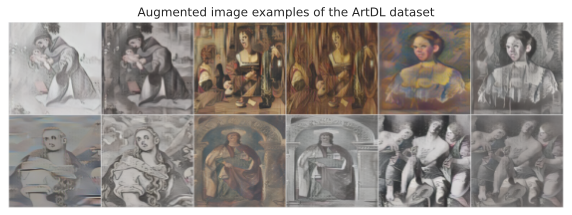

In [45]:
# Visualize some examples
#ONLY FOR VISUALISATION
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in val_data_contrast[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)
plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the ArtDL dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

**Pretraining the SimCLR-net**

In [ ]:

class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters('hidden_dim','lr','temperature','weight_decay',"max_epochs")
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet50(pretrained=False,
                                                   num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        #self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        wandb.log({mode+' accuracy_top1': (sim_argsort == 0).float().mean(),
                   mode+' accuracy_top5': (sim_argsort <5).float().mean(),
                   mode+ ' loss': nll})
        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [ ]:

def train_simclr(resume,batch_size, max_epochs, **kwargs,):
    #wandb.init(project="SimCLR_Standard",resume=allow,id = "SimCLR_Test")
    train_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=0)
    val_loader = data.DataLoader(val_data_contrast, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=0)
    

    if os.path.exists(os.path.join(CHECKPOINT_PATH,filename))and resume == False:
        print("load finished model")
        model = SimCLR.load_from_checkpoint(checkpoint_path=os.path.join(CHECKPOINT_PATH,filename))
        return model

    if os.path.exists(os.path.join(CHECKPOINT_PATH,filename))and resume:
        wandb.init(project=filename,resume="allow",id = filename)
        print("resume_training")
        #checkpoint_callback = ModelCheckpoint(dirpath=CHECKPOINT_PATH,filename = filename)

        trainer = pl.Trainer(
                             gpus=1 if str(device)=='cuda:0' else 0,
                             max_epochs=max_epochs,
                             #callbacks=[checkpoint_callback],
                             progress_bar_refresh_rate=1)
        
        model = SimCLR.load_from_checkpoint(checkpoint_path=os.path.join(CHECKPOINT_PATH,filename))
        trainer.fit(model, train_loader, val_loader,ckpt_path=os.path.join(CHECKPOINT_PATH,filename))

    #First Training Step
    else:
        print("start_training")
        wandb.init(project=filename,resume="allow",id = filename)
        #checkpoint_callback = ModelCheckpoint(dirpath=CHECKPOINT_PATH,filename = filename)
        trainer = pl.Trainer(gpus=1 if str(device)=='cuda:0' else 0,
                         max_epochs=max_epochs,
                         #callbacks=[checkpoint_callback],
                         progress_bar_refresh_rate=1)
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)

    trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH,filename))

    return model

In [ ]:
#Set Resume to False if you just want to load model
#max_epochs is dependent on how many epochs you already trained!

#set to False this if you want to start training for the first time
dont_override = False
if dont_override and os.path.exists(os.path.join(CHECKPOINT_PATH,filename)) == False:
  print("DONT OVERRIDE")
else:
  simclr_model = train_simclr(resume = True,
                            batch_size=40,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=1)


start_training


val accuracy_top1,▁█
val accuracy_top5,▁█
val loss,█▁
train accuracy_top1,0
train accuracy_top5,0.05
train loss,4.37006
val accuracy_top1,0.0125
val accuracy_top5,0.0875
val loss,4.36909


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | convnet | ResNet | 24.6 M
-----------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.491    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]